In [1]:
#| default_exp models.gru

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

#  GRU

Cho et. al proposed the Gated Recurrent Unit (`GRU`) to improve on LSTM and Elman cells. The predictions at each time are given by a MLP decoder. This architecture follows closely the original Multi Layer Elman `RNN` with the main difference being its use of the GRU cells. The predictions are obtained by transforming the hidden states into contexts $\mathbf{c}_{[t+1:t+H]}$, that are decoded and adapted into $\mathbf{\hat{y}}_{[t+1:t+H],[q]}$ through MLPs.

\begin{align}
 \mathbf{h}_{t} &= \textrm{GRU}([\mathbf{y}_{t},\mathbf{x}^{(h)}_{t},\mathbf{x}^{(s)}], \mathbf{h}_{t-1})\\
\mathbf{c}_{[t+1:t+H]}&=\textrm{Linear}([\mathbf{h}_{t}, \mathbf{x}^{(f)}_{[:t+H]}]) \\ 
\hat{y}_{\tau,[q]}&=\textrm{MLP}([\mathbf{c}_{\tau},\mathbf{x}^{(f)}_{\tau}])
\end{align}

where $\mathbf{h}_{t}$, is the hidden state for time $t$, $\mathbf{y}_{t}$ is the input at time $t$ and $\mathbf{h}_{t-1}$ is the hidden state of the previous layer at $t-1$, $\mathbf{x}^{(s)}$ are static exogenous inputs, $\mathbf{x}^{(h)}_{t}$ historic exogenous, $\mathbf{x}^{(f)}_{[:t+H]}$ are future exogenous available at the time of the prediction.

**References**<br>
-[Junyoung Chung, Caglar Gulcehre, KyungHyun Cho, Yoshua Bengio (2014). "Empirical Evaluation of Gated Recurrent Neural Networks on Sequence Modeling".](https:arxivorg/abs/1412.3555)<br>
-[Kyunghyun Cho, Bart van Merrienboer, Dzmitry Bahdanau, Yoshua Bengio (2014). "On the Properties of Neural Machine Translation: Encoder-Decoder Approaches".](https://arxiv.org/abs/1409.1259)<br>

![Figure 1. Gated Recurrent Unit Cell.](imgs_models/gru.png)

In [3]:
#| hide
from nbdev.showdoc import show_doc

In [4]:
#| export
import torch
import torch.nn as nn

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_recurrent import BaseRecurrent
from neuralforecast.common._modules import MLP

In [5]:
#| export
class GRU(BaseRecurrent):
    """ GRU

    Multi Layer Recurrent Network with Gated Units (GRU), and
    MLP decoder. The network has `tanh` or `relu` non-linearities, it is trained 
    using ADAM stochastic gradient descent. The network accepts static, historic 
    and future exogenous data, flattens the inputs.

        **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
    `encoder_n_layers`: int=2, number of layers for the GRU.<br>
    `encoder_hidden_size`: int=200, units for the GRU's hidden state size.<br>
    `encoder_activation`: str=`tanh`, type of GRU activation from `tanh` or `relu`.<br>
    `encoder_bias`: bool=True, whether or not to use biases b_ih, b_hh within GRU units.<br>
    `encoder_dropout`: float=0., dropout regularization applied to GRU outputs.<br>
    `context_size`: int=10, size of context vector for each timestamp on the forecasting window.<br>
    `decoder_hidden_size`: int=200, size of hidden layer for the MLP decoder.<br>
    `decoder_layers`: int=2, number of layers for the MLP decoder.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `learning_rate`: float=1e-3, initial optimization learning rate (0,1).<br>
    `batch_size`: int=32, number of differentseries in each batch.<br>
    `scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    
    """
    def __init__(self,
                 h: int,
                 input_size: int = -1,
                 encoder_n_layers: int = 2,
                 encoder_hidden_size: int = 200,
                 encoder_activation: str = 'tanh',
                 encoder_bias: bool = True,
                 encoder_dropout: float = 0.,
                 context_size: int = 10,
                 decoder_hidden_size: int = 200,
                 decoder_layers: int = 2,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 loss=MAE(),
                 learning_rate: float = 1e-3,
                 batch_size=32,
                 scaler_type: str='robust',
                 random_seed=1,
                 num_workers_loader=0,
                 drop_last_loader=False,
                 **trainer_kwargs):
        super(GRU, self).__init__(
            h = h,
            input_size = input_size,
            loss=loss,
            learning_rate = learning_rate,
            batch_size=batch_size,
            scaler_type=scaler_type,
            futr_exog_list=futr_exog_list,
            hist_exog_list=hist_exog_list,
            stat_exog_list=stat_exog_list,
            num_workers_loader=num_workers_loader,
            drop_last_loader=drop_last_loader,
            random_seed=random_seed,
            **trainer_kwargs
        )

        # RNN
        self.encoder_n_layers = encoder_n_layers
        self.encoder_hidden_size = encoder_hidden_size
        self.encoder_bias = encoder_bias
        self.encoder_dropout = encoder_dropout
        
        # Context adapter
        self.context_size = context_size

        # MLP decoder
        self.decoder_hidden_size = decoder_hidden_size
        self.decoder_layers = decoder_layers

        self.futr_exog_size = len(self.futr_exog_list)
        self.hist_exog_size = len(self.hist_exog_list)
        self.stat_exog_size = len(self.stat_exog_list)
        
        # RNN input size (1 for target variable y)
        input_encoder = 1 + self.hist_exog_size + self.stat_exog_size

        # Instantiate model
        self.hist_encoder = nn.GRU(input_size=input_encoder,
                                   hidden_size=self.encoder_hidden_size,
                                   num_layers=self.encoder_n_layers,
                                   bias=self.encoder_bias,
                                   dropout=self.encoder_dropout,
                                   batch_first=True)

        # Context adapter
        self.context_adapter = nn.Linear(in_features=self.encoder_hidden_size + self.futr_exog_size * h,
                                         out_features=self.context_size * h)

        # Decoder MLP
        self.mlp_decoder = MLP(in_features=self.context_size + self.futr_exog_size,
                               out_features=self.loss.outputsize_multiplier,
                               hidden_size=self.decoder_hidden_size,
                               num_layers=self.decoder_layers,
                               activation='ReLU',
                               dropout=0.0)

    def forward(self, windows_batch):
        
        # Parse windows_batch
        encoder_input = windows_batch['insample_y'] # [B, seq_len, 1]
        futr_exog     = windows_batch['futr_exog']
        hist_exog     = windows_batch['hist_exog']
        stat_exog     = windows_batch['stat_exog']

        # Concatenate y, historic and static inputs
        # [B, C, seq_len, 1] -> [B, seq_len, C]
        # Contatenate [ Y_t, | X_{t-L},..., X_{t} | S ]
        batch_size, seq_len = encoder_input.shape[:2]
        if self.hist_exog_size > 0:
            hist_exog = hist_exog.permute(0,2,1,3).squeeze(-1) # [B, X, seq_len, 1] -> [B, seq_len, X]
            encoder_input = torch.cat((encoder_input, hist_exog), dim=2)

        if self.stat_exog_size > 0:
            stat_exog = stat_exog.unsqueeze(1).repeat(1, seq_len, 1) # [B, S] -> [B, seq_len, S]
            encoder_input = torch.cat((encoder_input, stat_exog), dim=2)

        # RNN forward
        hidden_state, _ = self.hist_encoder(encoder_input) # [B, seq_len, rnn_hidden_state]

        if self.futr_exog_size > 0:
            futr_exog = futr_exog.permute(0,2,3,1)[:,:,1:,:]  # [B, F, seq_len, 1+H] -> [B, seq_len, H, F]
            hidden_state = torch.cat(( hidden_state, futr_exog.reshape(batch_size, seq_len, -1)), dim=2)

        # Context adapter
        context = self.context_adapter(hidden_state)
        context = context.reshape(batch_size, seq_len, self.h, self.context_size)

        # Residual connection with futr_exog
        if self.futr_exog_size > 0:
            context = torch.cat((context, futr_exog), dim=-1)

        # Final forecast
        output = self.mlp_decoder(context)
        output = self.loss.domain_map(output)
        
        return output

In [6]:
show_doc(GRU)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/gru.py#L15){target="_blank" style="float:right; font-size:smaller"}

### GRU

>      GRU (h:int, input_size:int=-1, encoder_n_layers:int=2,
>           encoder_hidden_size:int=200, encoder_activation:str='tanh',
>           encoder_bias:bool=True, encoder_dropout:float=0.0,
>           context_size:int=10, decoder_hidden_size:int=200,
>           decoder_layers:int=2, futr_exog_list=None, hist_exog_list=None,
>           stat_exog_list=None, loss=MAE(), learning_rate:float=0.001,
>           batch_size=32, scaler_type:str='robust', random_seed=1,
>           num_workers_loader=0, drop_last_loader=False, **trainer_kwargs)

GRU

Multi Layer Recurrent Network with Gated Units (GRU), and
MLP decoder. The network has `tanh` or `relu` non-linearities, it is trained 
using ADAM stochastic gradient descent. The network accepts static, historic 
and future exogenous data, flattens the inputs.

    **Parameters:**<br>
`h`: int, forecast horizon.<br>
`input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
`encoder_n_layers`: int=2, number of layers for the GRU.<br>
`encoder_hidden_size`: int=200, units for the GRU's hidden state size.<br>
`encoder_activation`: str=`tanh`, type of GRU activation from `tanh` or `relu`.<br>
`encoder_bias`: bool=True, whether or not to use biases b_ih, b_hh within GRU units.<br>
`encoder_dropout`: float=0., dropout regularization applied to GRU outputs.<br>
`context_size`: int=10, size of context vector for each timestamp on the forecasting window.<br>
`decoder_hidden_size`: int=200, size of hidden layer for the MLP decoder.<br>
`decoder_layers`: int=2, number of layers for the MLP decoder.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`learning_rate`: float=1e-3, initial optimization learning rate (0,1).<br>
`batch_size`: int=32, number of differentseries in each batch.<br>
`scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

In [7]:
show_doc(GRU.fit, name='GRU.fit')

---

### GRU.fit

>      GRU.fit (dataset, val_size=0, test_size=0)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `batch_size`, ...)
and the `loss` function as defined during the initialization. 
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect 
disk memory, to get them change `enable_checkpointing=True` in `__init__`.        

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [8]:
show_doc(GRU.predict, name='GRU.predict')

---

### GRU.predict

>      GRU.predict (dataset, step_size=1, **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`step_size`: int=1, Step size between each window.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

## Usage Example

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[]

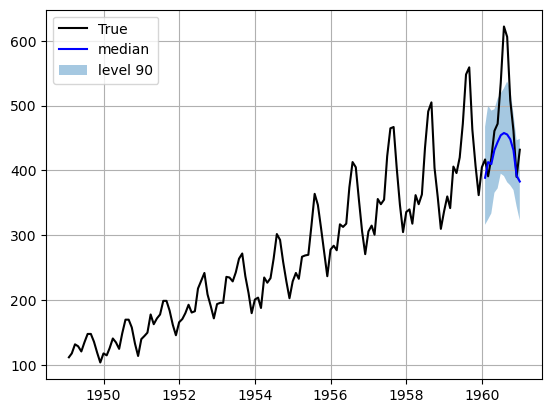

In [9]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

fcst = NeuralForecast(
    models=[GRU(h=12,input_size=-1,
                #loss=MAE(),
                #loss=MQLoss(level=[80, 90]),
                loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                scaler_type='robust',
                encoder_n_layers=2,
                encoder_hidden_size=128,
                context_size=10,
                decoder_hidden_size=128,
                decoder_layers=2,
                max_epochs=100,
                futr_exog_list=None,
                hist_exog_list=['y_[lag12]'],
                stat_exog_list=['airline1'],
                )
    ],
    freq='M'
)
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic)
forecasts = fcst.predict(futr_df=Y_test_df)

Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
try:
    plt.plot(plot_df['ds'], plot_df['GRU-median'], c='blue', label='median')
    plt.fill_between(x=plot_df['ds'], 
                     y1=plot_df['GRU-lo-90.0'], y2=plot_df['GRU-hi-90.0'],
                     alpha=0.4, label='level 90')
except:
    plt.plot(plot_df['ds'], plot_df['GRU'], c='blue', label='median')
plt.legend()
plt.grid()
plt.plot()